In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely 
import fiona
import pyproj
import matplotlib.pyplot as plt

# Load hurricane tracks
Tracks from 1901-Aug 2024, SSHS cleaned and valid

In [2]:
tracks = gpd.read_file('data\hurricane_track_data\IBTrACS_NA_20240819_SSHSclean_1901.shp')

In [3]:
tracks

,SID,SEASON,NUMBER,SUBBASIN,NAME,ISO_TIME,USA_WIND,USA_STATUS,USA_SSHS,year,month,day,hour,min,SSHS_clean,geometry
0,1901162N19278,1901,19,CS,UNNAMED,1901-06-11 00:00:00,25.0,TD,-1,1901,6,11,0,0,0,"LINESTRING (-82.30005 19.3, -82.69995 19.7)"
1,1901162N19278,1901,19,CS,UNNAMED,1901-06-11 03:00:00,25.0,TD,-1,1901,6,11,3,0,0,"LINESTRING (-82.69995 19.7, -83 20)"
2,1901162N19278,1901,19,CS,UNNAMED,1901-06-11 06:00:00,25.0,TD,-1,1901,6,11,6,0,0,"LINESTRING (-83 20, -83.30005 20.3)"
3,1901162N19278,1901,19,CS,UNNAMED,1901-06-11 09:00:00,28.0,TD,-1,1901,6,11,9,0,0,"LINESTRING (-83.30005 20.3, -83.5 20.7)"
4,1901162N19278,1901,19,CS,UNNAMED,1901-06-11 12:00:00,30.0,TD,-1,1901,6,11,12,0,0,"LINESTRING (-83.5 20.7, -83.69995 21)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87393,2024222N11327,2024,40,NA,ERNESTO,2024-08-17 09:00:00,73.0,HU,1,2024,8,17,9,0,1,"LINESTRING (-64.80005 32.3, -64.5 32.6)"
87394,2024222N11327,2024,40,NA,ERNESTO,2024-08-17 12:00:00,70.0,HU,1,2024,8,17,12,0,1,"LINESTRING (-64.5 32.6, -64.40002 32.8)"
87395,2024222N11327,2024,40,NA,ERNESTO,2024-08-17 15:00:00,68.0,HU,1,2024,8,17,15,0,1,"LINESTRING (-64.40002 32.8, -64.19995 33)"
87396,2024222N11327,2024,40,NA,ERNESTO,2024-08-17 18:00:00,65.0,HU,1,2024,8,17,18,0,1,"LINESTRING (-64.19995 33, -63.90002 33.2)"


# Import analysis point and set CRS
In ArcGIS, the centroid for the combined Houston-Galveston counties ploygon was found. Import this as the analysis point and convert to the proper CRS.

In [4]:
# create return period analysis point for Houston-Galveston

analysis_pt_df = pd.DataFrame(
    {
        "Polygon": ["Combined Houston-Galveston county bounds"],
        "Latitude": [3465238.7015447523],
        "Longitude": [-10599723.208314808],
    }
)

In [5]:
analysis_pt_gdf = gpd.GeoDataFrame(
    analysis_pt_df, geometry=gpd.points_from_xy(analysis_pt_df.Longitude, analysis_pt_df.Latitude), crs="EPSG:3857"
)

In [6]:
analysis_pt_gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
tracks.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Convert all points to CRS EPSG:3081 (NAD83/Texas State Mapping System) so units are in meters

In [8]:
analysis_pt_gdf = analysis_pt_gdf.to_crs('epsg:3081')
tracks = tracks.to_crs('epsg:3081')

In [9]:
print(tracks.crs)
print(analysis_pt_gdf.crs)

epsg:3081
epsg:3081


In [10]:
analysis_pt_gdf

,Polygon,Latitude,Longitude,geometry
0,Combined Houston-Galveston county bounds,3.465239e+06,-1.059972e+07,POINT (1461706.549 847878.62)


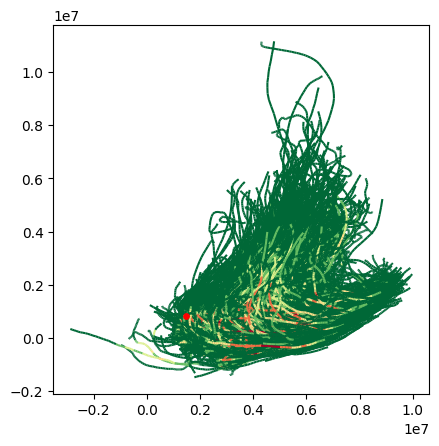

In [11]:
# plot tracks data with analysis point to check location

fig, ax = plt.subplots()

tracks.plot(ax=ax, column = 'SSHS_clean', cmap = 'RdYlGn_r')
analysis_pt_gdf.plot(ax=ax, color='red', markersize=15, zorder=10)

plt.show();


# Count hurricane strikes at analysis point

In [12]:
ptdist = pd.DataFrame(columns = ["Distance","SID","Storm","Year","SSHS","USA_WIND"]) #create empty dataframe to store distance results

for i,j in tracks.iterrows():
    dist = analysis_pt_gdf['geometry'].distance(j['geometry'])
    if dist[0] < 92600: #if within strike distance of 50 nautical miles (92,600 meters), add attributes to ptdist dataframe
        ptdist.loc[ptdist.shape[0]] = [dist[0], j["SID"], j["NAME"], j["SEASON"], j["SSHS_clean"], j["USA_WIND"]]
ptdist

,Distance,SID,Storm,Year,SSHS,USA_WIND
0,89047.069306,1909195N12300,UNNAMED,1909,3,100.0
1,82274.070785,1909195N12300,UNNAMED,1909,3,100.0
2,81916.076956,1909195N12300,UNNAMED,1909,2,90.0
3,91205.609453,1915218N14334,UNNAMED,1915,4,115.0
4,56678.882389,1915218N14334,UNNAMED,1915,4,115.0
...,...,...,...,...,...,...
241,50134.252761,2021256N21265,NICHOLAS,2021,0,33.0
242,82020.086351,2021256N21265,NICHOLAS,2021,0,30.0
243,86203.122422,2024178N09335,BERYL,2024,1,68.0
244,58412.566709,2024178N09335,BERYL,2024,1,65.0


In [13]:
#filter out points by maximum wind speed so only the highest hurricane category within 50 nautical miles is assigned to each analysis point, for each SID
ptdist_max = ptdist[ptdist.groupby(['SID'])['USA_WIND'].transform(max) == ptdist['USA_WIND']]
ptdist_max

C:\Users\kb42628\AppData\Local\Temp\ipykernel_17300\3157967099.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ptdist_max = ptdist[ptdist.groupby(['SID'])['USA_WIND'].transform(max) == ptdist['USA_WIND']]


,Distance,SID,Storm,Year,SSHS,USA_WIND
0,89047.069306,1909195N12300,UNNAMED,1909,3,100.0
1,82274.070785,1909195N12300,UNNAMED,1909,3,100.0
3,91205.609453,1915218N14334,UNNAMED,1915,4,115.0
4,56678.882389,1915218N14334,UNNAMED,1915,4,115.0
5,28351.617244,1915218N14334,UNNAMED,1915,4,115.0
...,...,...,...,...,...,...
233,13882.400327,2020261N21265,BETA,2020,0,25.0
234,21149.776308,2020261N21265,BETA,2020,0,25.0
235,68225.251639,2020261N21265,BETA,2020,0,25.0
236,66645.827191,2021256N21265,NICHOLAS,2021,1,65.0


In [14]:
#Remove duplicate records by only keeping the first entry for each analysis point
ptdist_max_first = ptdist_max.groupby(['SID']).first().reset_index()
ptdist_max_first

,SID,Distance,Storm,Year,SSHS,USA_WIND
0,1909195N12300,89047.069306,UNNAMED,1909,3,100.0
1,1915218N14334,91205.609453,UNNAMED,1915,4,115.0
2,1921167N17278,76321.338642,UNNAMED,1921,1,65.0
3,1932225N22270,71894.970568,UNNAMED,1932,4,130.0
4,1934238N27271,83424.416931,UNNAMED,1934,1,70.0
5,1938284N16273,74874.477528,UNNAMED,1938,0,40.0
6,1940217N29277,89385.437620,UNNAMED,1940,2,85.0
7,1940263N12279,77962.498493,UNNAMED,1940,0,40.0
8,1941254N27273,88764.731498,UNNAMED,1941,0,30.0
9,1941261N24272,85972.125714,UNNAMED,1941,3,110.0


# Calculate return periods

In [15]:
strikes = ptdist_max_first.groupby(['SSHS']).SSHS.agg('count').to_frame('Strikes').T
strikes

SSHS,0,1,2,3,4
Strikes,24,12,4,3,2


In [16]:
strikes.columns

Index([0, 1, 2, 3, 4], dtype='int64', name='SSHS')

In [17]:
strikes.rename(columns={0: 'Cat0', 1: 'Cat1', 2: 'Cat2', 3: 'Cat3', 4: 'Cat4'}, inplace=True)

In [18]:
strikes

SSHS,Cat0,Cat1,Cat2,Cat3,Cat4
Strikes,24,12,4,3,2


In [19]:
# Jan 1, 1901 was 45,147 days ago from Aug 20, 2024; convert to years

45147 / 365.25

123.60574948665298

In [20]:
strikesRP = strikes

strikesRP['RP0'] = 123.606 / strikesRP.loc[:, 'Cat0':'Cat5'].sum(axis=1)
strikesRP['RP1'] = 123.606 / strikesRP.loc[:, 'Cat1':'Cat5'].sum(axis=1)
strikesRP['RP2'] = 123.606 / strikesRP.loc[:, 'Cat2':'Cat5'].sum(axis=1)
strikesRP['RP3'] = 123.606 / strikesRP.loc[:, 'Cat3':'Cat5'].sum(axis=1)
strikesRP['RP4'] = 123.606 / strikesRP.loc[:, 'Cat4':'Cat5'].sum(axis=1)
strikesRP['RP5'] = 123.606 / strikesRP.loc[:, 'Cat5':'Cat5'].sum(axis=1)

strikesRP


SSHS,Cat0,Cat1,Cat2,Cat3,Cat4,RP0,RP1,RP2,RP3,RP4,RP5
Strikes,24,12,4,3,2,2.7468,5.886,13.734,24.7212,61.803,inf


In [21]:
print('Return periods (years) for:\nTropical storm:', strikesRP['RP0'][0], 
      '\nHurricane:', strikesRP['RP1'][0],
      '\nMajor hurricane:', strikesRP['RP3'][0])

Return periods (years) for:
Tropical storm: 2.7468 
Hurricane: 5.886 
Major hurricane: 24.7212


C:\Users\kb42628\AppData\Local\Temp\ipykernel_17300\3181277984.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Return periods (years) for:\nTropical storm:', strikesRP['RP0'][0],
C:\Users\kb42628\AppData\Local\Temp\ipykernel_17300\3181277984.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  '\nHurricane:', strikesRP['RP1'][0],
C:\Users\kb42628\AppData\Local\Temp\ipykernel_17300\3181277984.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

In [26]:
strikesRP.iloc[:, -5:]

SSHS,RP1,RP2,RP3,RP4,RP5
Strikes,5.886,13.734,24.7212,61.803,inf


In [27]:
strikesRP.iloc[:, -5:].to_csv('data\hurricaneRPs.csv')